In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class OccMatrix():
    def __init__(self, dim=[10,10], free_space=None, occ_space=None, resolution=0.1, origin=[0, 0]):
        """
        Inizializza una matrice di occupazione.
        
        Args:
        - dim: Dimensioni della griglia (larghezza e altezza in metri).
        - free_space: Lista di celle libere (valore = 0).
        - occ_space: Lista di celle occupate (valore = 1).
        - resolution: Risoluzione della mappa (dimensione di una cella in metri).
        - origin: Coordinate mondo dell'origine della mappa (coordinate [0,0] della griglia).
        """
        self.width = int(np.ceil(dim[0]/resolution))
        self.height = int(np.ceil(dim[1]/resolution))
        self.resolution = resolution
        self.origin = origin  # Posizione in coordinate mondo dell'origine (cella [0,0])
        self.shape = [self.height, self.width]  # La forma della griglia (numero di righe, colonne)
        self.data = -1 * np.ones(self.shape)  # Inizializza la griglia con valori sconosciuti (-1)
        if free_space is not None:
            for cell in free_space:
                self.set_cell(cell[0], cell[1], 0)  # Celle libere
        if occ_space is not None:
            for cell in occ_space:
                self.set_cell(cell[0], cell[1], 1)  # Celle occupate
    def world_to_grid(self, x, y):
        """
        Converte le coordinate mondo (x, y) in coordinate griglia (riga, colonna).
        
        Args:
        - x, y: Coordinate mondo.
        
        Returns:
        - [riga, colonna]: Coordinate della griglia.
        """
        colonna = int((x - self.origin[0]) / self.resolution)
        riga = int((y - self.origin[1]) / self.resolution)
        return [riga, colonna]

    def grid_to_world(self, i, j):
        """
        Converte le coordinate griglia (riga, colonna) in coordinate mondo (x, y).
        
        Args:
        - i, j: Coordinate griglia.
        
        Returns:
        - [x, y]: Coordinate mondo del centro della cella.
        """
        # Calcola le coordinate del centro della cella (i, j)
        x = self.origin[0] + (j + 0.5) * self.resolution
        y = self.origin[1] + (i + 0.5) * self.resolution
        return [x, y]

    def set_cell(self, riga, colonna, value):
        """
        Imposta il valore di una cella nella matrice di occupazione.
        
        Args:
        - riga, colonna: Coordinate della cella nella griglia.
        - value: Valore da impostare (0 = libero, 1 = occupato, -1 = sconosciuto).
        """
        if 0 <= riga < self.height and 0 <= colonna < self.width:
            self.data[riga, colonna] = value

    def get_cell(self, riga, colonna):
        """
        Ottiene il valore di una cella nella matrice di occupazione.
        
        Args:
        - riga, colonna: Coordinate della cella nella griglia.
        
        Returns:
        - Valore della cella (0 = libero, 1 = occupato, -1 = sconosciuto).
        """
        if 0 <= riga < self.height and 0 <= colonna < self.width:
            return self.data[riga, colonna]
        else:
            return None  # Coordinate fuori dalla mappa

def lidar_raycast(pose, lidar_params, map):
    """
    Simula un raycast LIDAR su una mappa di occupazione.
    
    Args:
    - pose: Posizione (x, y, theta) del robot.
    - lidar_params: Parametri del LIDAR (numero di raggi, risoluzione angolare, raggio massimo).
    - map: Oggetto della classe OccupancyGridWrapper.
    
    Returns:
    - angles: Angoli dei raggi LIDAR.
    - ranges: Distanze misurate per ciascun raggio.
    - visible_cells: Celle visibili colpite dai raggi.
    """
    x0, y0, theta0 = pose
    data = map.data

    ray_num = lidar_params['ray_num']
    resolution = lidar_params['resolution']
    max_range = lidar_params['max_range']
    
    angles = np.zeros([ray_num])
    ranges = max_range * np.ones([ray_num])
    
    # Converte la posizione del robot in coordinate della griglia
    cell0 = map.world_to_grid(x0, y0)
    
    # Se la cella iniziale è occupata o sconosciuta, ritorna
    if map.get_cell(cell0[0], cell0[1]) != 0:
        return angles, ranges, None

    visible_cells = set()
    
    # Simulazione del raycast per ciascun raggio
    for i in range(ray_num):
        angle = np.deg2rad(i * resolution + theta0)
        angles[i] = np.rad2deg(angle)
        
        # Calcola l'avanzamento del raggio fino al raggio massimo
        for r in np.arange(0, max_range, 0.001):
            x = x0 + r * np.cos(angle)
            y = y0 + r * np.sin(angle)
            
            # Converte le coordinate mondo in coordinate griglia
            cell = map.world_to_grid(x, y)
            
            # Controlla se il raggio è uscito dai limiti della griglia
            if cell[0] >= data.shape[0] or cell[1] >= data.shape[1] or cell[0] < 0 or cell[1] < 0:
                break
            
            # Se la cella è occupata o sconosciuta, interrompi il raggio
            elif map.get_cell(cell[0], cell[1]) == 1 or map.get_cell(cell[0], cell[1]) == -1:
                ranges[i] = r
                visible_cells.add(tuple(cell))
                break
            
            # Altrimenti, aggiungi la cella come visibile
            else:
                visible_cells.add(tuple(cell))

    visible_cells = np.array(list(visible_cells))
    return angles, ranges, visible_cells

In [25]:
# Genero spazio libero e spazio occupato random
free_space = []
for i in range(1,10):
    for j in range(1,10):
        free_space.append([i,j])
occ_space = []
for i in range(4, 8):
    for j in range(4, 8):
        occ_space.append([i,j])

# Genero OccMatrix
map = OccMatrix(dim=[2,2], free_space=free_space, occ_space=occ_space)
matrix = map.data

# Simulo lidar
lidar_params = {'ray_num': 360, 'resolution':1, 'max_range':3.0}
pose = [0.25, 0.25, 0]
angles, ranges, visible_cells = lidar_raycast(pose, lidar_params, map)

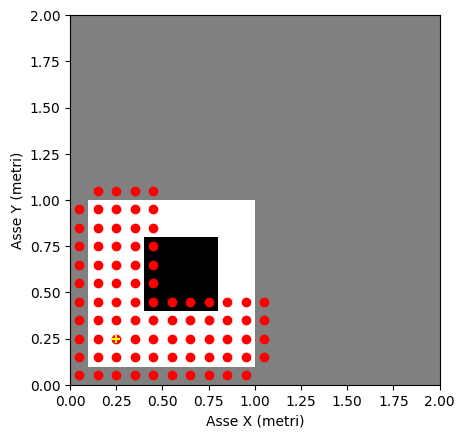

In [26]:
# Creare la colormap: grigio (sconosciuto), bianco (libero), nero (occupato)
cmap = colors.ListedColormap(['gray', 'white', 'black'])
bounds = [-1.5, -0.5, 0.5, 1.5]  # Limiti per i valori: -1 (sconosciuto), 0 (libero), 1 (occupato)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Calcolare l'estensione della mappa in coordinate del mondo
extent = [
    map.origin[0],  # Estensione asse X: dall'origine fino alla larghezza in metri
    map.origin[0] + map.width * map.resolution,
    map.origin[1],  # Estensione asse Y: dall'origine fino all'altezza in metri
    map.origin[1] + map.height * map.resolution
]

# Plottare la matrice di occupazione
plt.imshow(map.data, cmap=cmap, norm=norm, origin='lower', extent=extent)

if visible_cells is not None:
    visible_cells_world = [map.grid_to_world(*cell) for cell in visible_cells]
    visible_cells_x = [p[0] for p in visible_cells_world]
    visible_cells_y = [p[1] for p in visible_cells_world]
    plt.scatter(visible_cells_x, visible_cells_y, color='red', marker='o')

plt.scatter(pose[0], pose[1], color='yellow', marker='+')

# Aggiungere etichette agli assi
plt.xlabel('Asse X (metri)')
plt.ylabel('Asse Y (metri)')

# Mostrare il plot
plt.show()

In [ ]:
""" Classe che si dovrebbe interfacciare correttamente con ROS """

class OccupancyGridWrapper:
    def __init__(self, occupancy_grid):
        """
        Inizializza il wrapper per un oggetto OccupancyGrid di ROS.
        
        Args:
        - occupancy_grid: Messaggio di tipo OccupancyGrid proveniente da ROS.
        """
        self.grid = occupancy_grid
        self.resolution = occupancy_grid.info.resolution
        self.origin = [occupancy_grid.info.origin.position.x, occupancy_grid.info.origin.position.y]
        self.width = occupancy_grid.info.width
        self.height = occupancy_grid.info.height
        self.data = np.array(occupancy_grid.data).reshape((self.height, self.width))

    def world_to_grid(self, x, y):
        """
        Converte coordinate mondo (x, y) in coordinate griglia (riga, colonna).
        
        Args:
        - x, y: Coordinate mondo.
        
        Returns:
        - [riga, colonna]: Coordinate della griglia.
        """
        colonna = int((x - self.origin[0]) / self.resolution)
        riga = int((y - self.origin[1]) / self.resolution)
        return [riga, colonna]

    def grid_to_world(self, i, j):
        """
        Converte coordinate griglia (riga, colonna) in coordinate mondo (x, y).
        
        Args:
        - i, j: Coordinate griglia.
        
        Returns:
        - [x, y]: Coordinate mondo del centro della cella.
        """
        x = self.origin[0] + (j + 0.5) * self.resolution
        y = self.origin[1] + (i + 0.5) * self.resolution
        return [x, y]

    def get_cell(self, riga, colonna):
        """
        Ottiene il valore di una cella nella matrice di occupazione.
        
        Args:
        - riga, colonna: Coordinate della cella nella griglia.
        
        Returns:
        - Valore della cella (0 = libero, 1 = occupato, -1 = sconosciuto).
        """
        if 0 <= riga < self.height and 0 <= colonna < self.width:
            return self.data[riga, colonna]
        else:
            return None  # Coordinate fuori dalla mappa

    def set_cell(self, riga, colonna, value):
        """
        Imposta il valore di una cella nella matrice di occupazione.
        
        Args:
        - riga, colonna: Coordinate della cella nella griglia.
        - value: Valore da impostare (0 = libero, 1 = occupato, -1 = sconosciuto).
        """
        if 0 <= riga < self.height and 0 <= colonna < self.width:
            self.data[riga, colonna] = value
            # Aggiornare i dati nell'OccupancyGrid ROS
            self.grid.data[riga * self.width + colonna] = value

    def update_ros_grid(self):
        """
        Aggiorna i dati dell'OccupancyGrid di ROS con le modifiche effettuate alla griglia.
        """
        self.grid.data = self.data.flatten().tolist()

